# Context : Data cleaning and Feature engineering


Source : 



**Competition Description**




xxxx

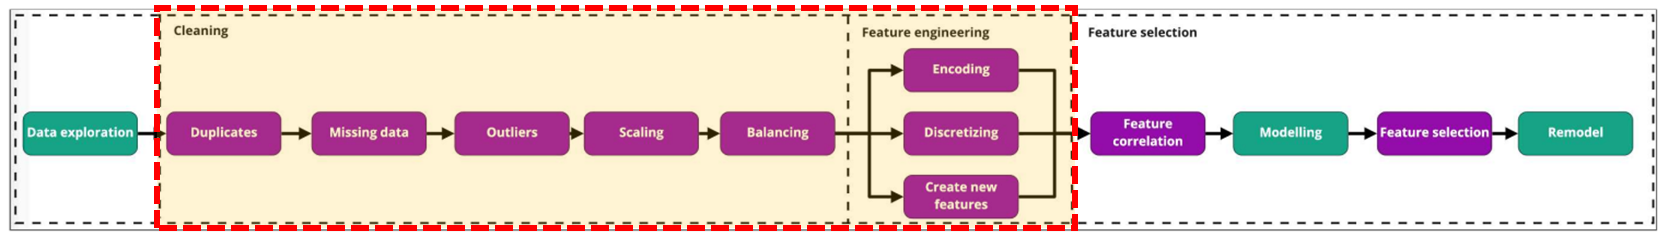



# Imports


In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import time

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer



# Retrieve data


## Get the raw data



In [2]:
#Retrieve data
path_to_data = '../data/raw_data/'
data = pd.read_csv(path_to_data + 'train.csv')
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Train test split


In [3]:
# Separating train set from test set
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

In [4]:
# Display shapes
print(f"Shape of train_set : {train_set.shape}")
print(f"Shape of test_set : {test_set.shape}")

Shape of train_set : (1022, 81)
Shape of test_set : (438, 81)


## Drop initial columns


In [5]:
#List the columns that won't be used (exemple : Id, Name, ...)
cols_to_drop = ['Id']

train_set = train_set.drop(columns=cols_to_drop)
train_set.shape


(1022, 80)

In [6]:
# Save initial number of columns
initial_number_cols = train_set.shape[1]
initial_number_cols

80

In [7]:
# list processed columns
processed = []
for col in cols_to_drop:
    processed.append(col)

processed

['Id']

# Cleaning Duplicates


In [8]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(train_set)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {train_set.duplicated().sum()}")

# Remove duplicates
# train_set = train_set.drop_duplicates() 

Number of rows : 1022
Number of duplicated rows : 0


# Cleaning Missing Data


<span style="font-family:Comic Sans MS; color:red">Let's check the missing data per column (in percentage) :  </span>


In [9]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(train_set)
missing_data

PoolQC          99.510763
MiscFeature     96.086106
Alley           93.542074
Fence           80.234834
FireplaceQu     47.651663
LotFrontage     18.590998
GarageYrBlt      5.283757
GarageCond       5.283757
GarageType       5.283757
GarageFinish     5.283757
GarageQual       5.283757
BsmtCond         2.544031
BsmtQual         2.544031
BsmtExposure     2.544031
BsmtFinType2     2.544031
BsmtFinType1     2.544031
MasVnrArea       0.293542
MasVnrType       0.293542
Electrical       0.097847
dtype: float64

## Missing values > Max_threshold



In [10]:
# Threshold for which we decide to drop the column
max_thres_missing = 90

# Retrieve the feature name of columns exceeding max threshold for missing values. 
high_missing_cols = missing_data[missing_data > 90].index.values.tolist()

high_missing_cols

['PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">If the missing values of a column exceeds a max threshold, we drop said columns from dataset :  </span>



In [11]:
# More than 90% is way too high, let's drop these features
for col in high_missing_cols:
    train_set.drop(columns=col, inplace=True)
    print(f"-- **{col}** has more than {max_thres_missing}% of missing values so {col} has been dropped from dataset\n")

-- **PoolQC** has more than 90% of missing values so PoolQC has been dropped from dataset

-- **MiscFeature** has more than 90% of missing values so MiscFeature has been dropped from dataset

-- **Alley** has more than 90% of missing values so Alley has been dropped from dataset



In [12]:
#List the columns that won't be used (exemple : Id, Name, ...)
for col in high_missing_cols:
    cols_to_drop.append(col)
    
cols_to_drop

['Id', 'PoolQC', 'MiscFeature', 'Alley']

In [13]:
print(f"We dropped the following columns : {high_missing_cols} ! ")

We dropped the following columns : ['PoolQC', 'MiscFeature', 'Alley'] ! 


In [14]:
# list processed columns
for col in high_missing_cols:
    processed.append(col)

processed

['Id', 'PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">Let's display the remaining missing data :  </span>



In [15]:
# Display the remaining missing data
missing_data = get_missing_data(train_set)
missing_data

Fence           80.234834
FireplaceQu     47.651663
LotFrontage     18.590998
GarageType       5.283757
GarageFinish     5.283757
GarageQual       5.283757
GarageCond       5.283757
GarageYrBlt      5.283757
BsmtQual         2.544031
BsmtFinType2     2.544031
BsmtFinType1     2.544031
BsmtExposure     2.544031
BsmtCond         2.544031
MasVnrArea       0.293542
MasVnrType       0.293542
Electrical       0.097847
dtype: float64

In [16]:
# Determine type of missing columns
columns_missing = missing_data.index.values.tolist()
missing_cols_type = train_set[columns_missing].dtypes

#Identify the categorical columns with missing values
missing_cols_categorical = missing_cols_type[missing_cols_type == 'object'].index.values.tolist()
missing_cols_categorical;

#Identify the numerical columns with missing values
missing_cols_numerical = missing_cols_type[missing_cols_type != 'object'].index.values.tolist()
missing_cols_numerical;

<span style="font-family:Comic Sans MS; color:red">Let's display the categorical columns with missing values :  </span>




In [17]:
missing_cols_categorical

['Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtExposure',
 'BsmtCond',
 'MasVnrType',
 'Electrical']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns with missing values :  </span>

In [18]:
missing_cols_numerical

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

### Missing values : Categorical columns


<span style="font-family:Comic Sans MS; color:red">/!\ It is important to check the meaning of a NAN value in the documentation !  </span>


<span style="font-family:Comic Sans MS; color:red">/!\ If np.nan can be replaced by "NA", we use a simple imputer !  </span>



In [19]:
# Replace nan values by a replacement value
replace_value = "NA"

#Simple Imputer for nan values    
nan_imputer = SimpleImputer(missing_values = np.nan,          
                      strategy='constant', 
                      fill_value = replace_value)

In [20]:
#Check for unique values of each categorical col, 
#Replace nan values by a replacement value 
#and finally perform a value counts.
for col in missing_cols_categorical:
    print(f"-------------  {col}  ----------------------------------")
    print( f"Unique values: {train_set[col].unique()}\n")
    train_set[col] = nan_imputer.fit_transform(train_set[[col]])
    print(f"Nans have been replaced by {replace_value}.\n")
    print(train_set[col].value_counts()) 
    print(f"--------------------------------------------------------\n")

-------------  Fence  ----------------------------------
Unique values: ['MnPrv' nan 'GdPrv' 'GdWo' 'MnWw']

Nans have been replaced by NA.

NA       820
MnPrv    112
GdPrv     41
GdWo      41
MnWw       8
Name: Fence, dtype: int64
--------------------------------------------------------

-------------  FireplaceQu  ----------------------------------
Unique values: ['Gd' nan 'TA' 'Ex' 'Fa' 'Po']

Nans have been replaced by NA.

NA    487
Gd    261
TA    219
Fa     23
Ex     18
Po     14
Name: FireplaceQu, dtype: int64
--------------------------------------------------------

-------------  GarageType  ----------------------------------
Unique values: ['Attchd' 'Basment' 'BuiltIn' 'Detchd' nan 'CarPort' '2Types']

Nans have been replaced by NA.

Attchd     604
Detchd     275
BuiltIn     64
NA          54
Basment     14
CarPort      7
2Types       4
Name: GarageType, dtype: int64
--------------------------------------------------------

-------------  GarageFinish  ----------------------

In [21]:
# list processed columns
for col in missing_cols_categorical:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtExposure',
 'BsmtCond',
 'MasVnrType',
 'Electrical']

### Missing values : Numerical columns


<span style="font-family:Comic Sans MS; color:red">Let's draw the histograms to have an idea of the distribution of the numerical columns that have missing values ! </span>




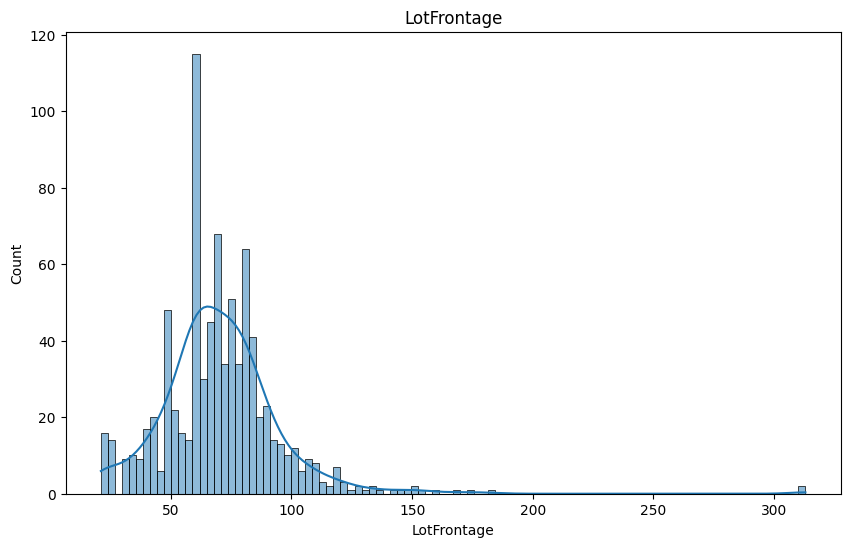

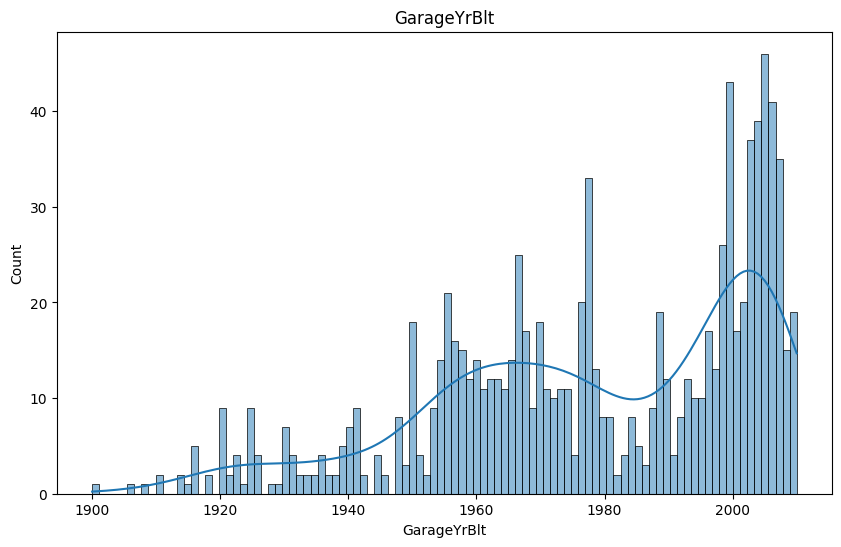

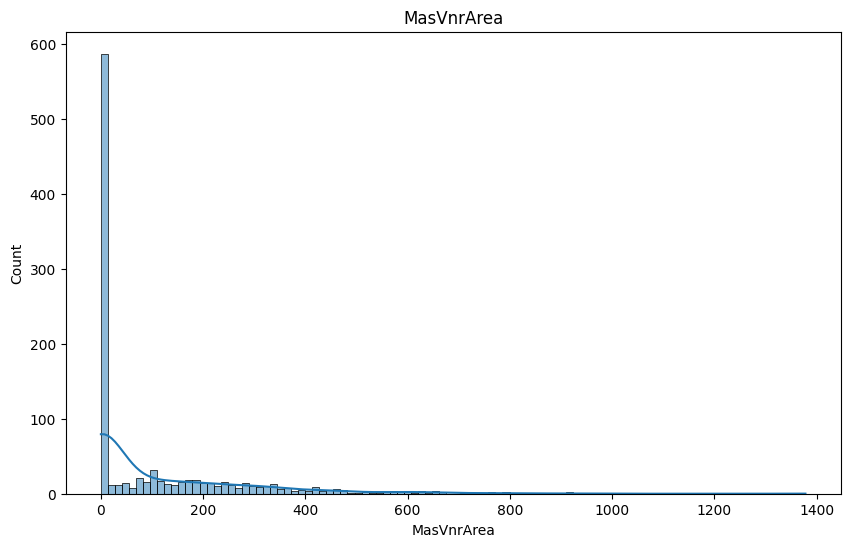

In [22]:
# Display hist plots for numerical features with missing values.
for col in missing_cols_numerical:   
    plt.figure(figsize=(10, 6))
    sns.histplot(train_set[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

In [23]:
# Display statistics of numerical features with missing values.
for col in missing_cols_numerical:   
    print(f"-------------  {col}  ----------------------------------")
    print(train_set[col].describe())
    print(f"--------------------------------------------------------\n")
    

-------------  LotFrontage  ----------------------------------
count    832.000000
mean      70.375000
std       25.533607
min       21.000000
25%       59.000000
50%       70.000000
75%       80.000000
max      313.000000
Name: LotFrontage, dtype: float64
--------------------------------------------------------

-------------  GarageYrBlt  ----------------------------------
count     968.000000
mean     1978.676653
std        24.814634
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
--------------------------------------------------------

-------------  MasVnrArea  ----------------------------------
count    1019.000000
mean      105.261040
std       172.707705
min         0.000000
25%         0.000000
50%         0.000000
75%       170.000000
max      1378.000000
Name: MasVnrArea, dtype: float64
--------------------------------------------------------



#### Replace with mean value


<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the mean value of the distribution ! </span>





<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [24]:
# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']
mean_imputer = SimpleImputer(strategy='mean')

#Fit transform
for col in missing_cols_numerical_mean:
    train_set[col] = mean_imputer.fit_transform(train_set[[col]])   

In [25]:
# list processed columns
for col in missing_cols_numerical_mean:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtExposure',
 'BsmtCond',
 'MasVnrType',
 'Electrical',
 'LotFrontage']

#### Replace by most_frequent

<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the most frequent value of the distribution ! </span>






<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [26]:
# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

#Fit transform
for col in missing_cols_numerical_most_freq:
    train_set[col] = most_frequent_imputer.fit_transform(train_set[[col]])  

In [27]:
# list processed columns
for col in missing_cols_numerical_most_freq:
    processed.append(col)

processed


['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtExposure',
 'BsmtCond',
 'MasVnrType',
 'Electrical',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt']

### Final check for missing values

In [28]:
# Display the remaining missing data
missing_data = get_missing_data(train_set)
missing_data

Series([], dtype: float64)

### Copy


<span style="font-family:Comic Sans MS; color:red"> Copy the dataframe after processing missing values and so on : </span>







In [29]:
traditional_process_df = train_set.copy()
traditional_process_df;


# Check outliers

In [30]:
# Extract numerical columns from original dataset
numerical_columns = train_set.select_dtypes(include = np.number).columns

#We don't take SalePrice into account on purpose
numerical_columns = numerical_columns.drop('SalePrice') 
numerical_columns.shape


(36,)

## Visual check for outliers


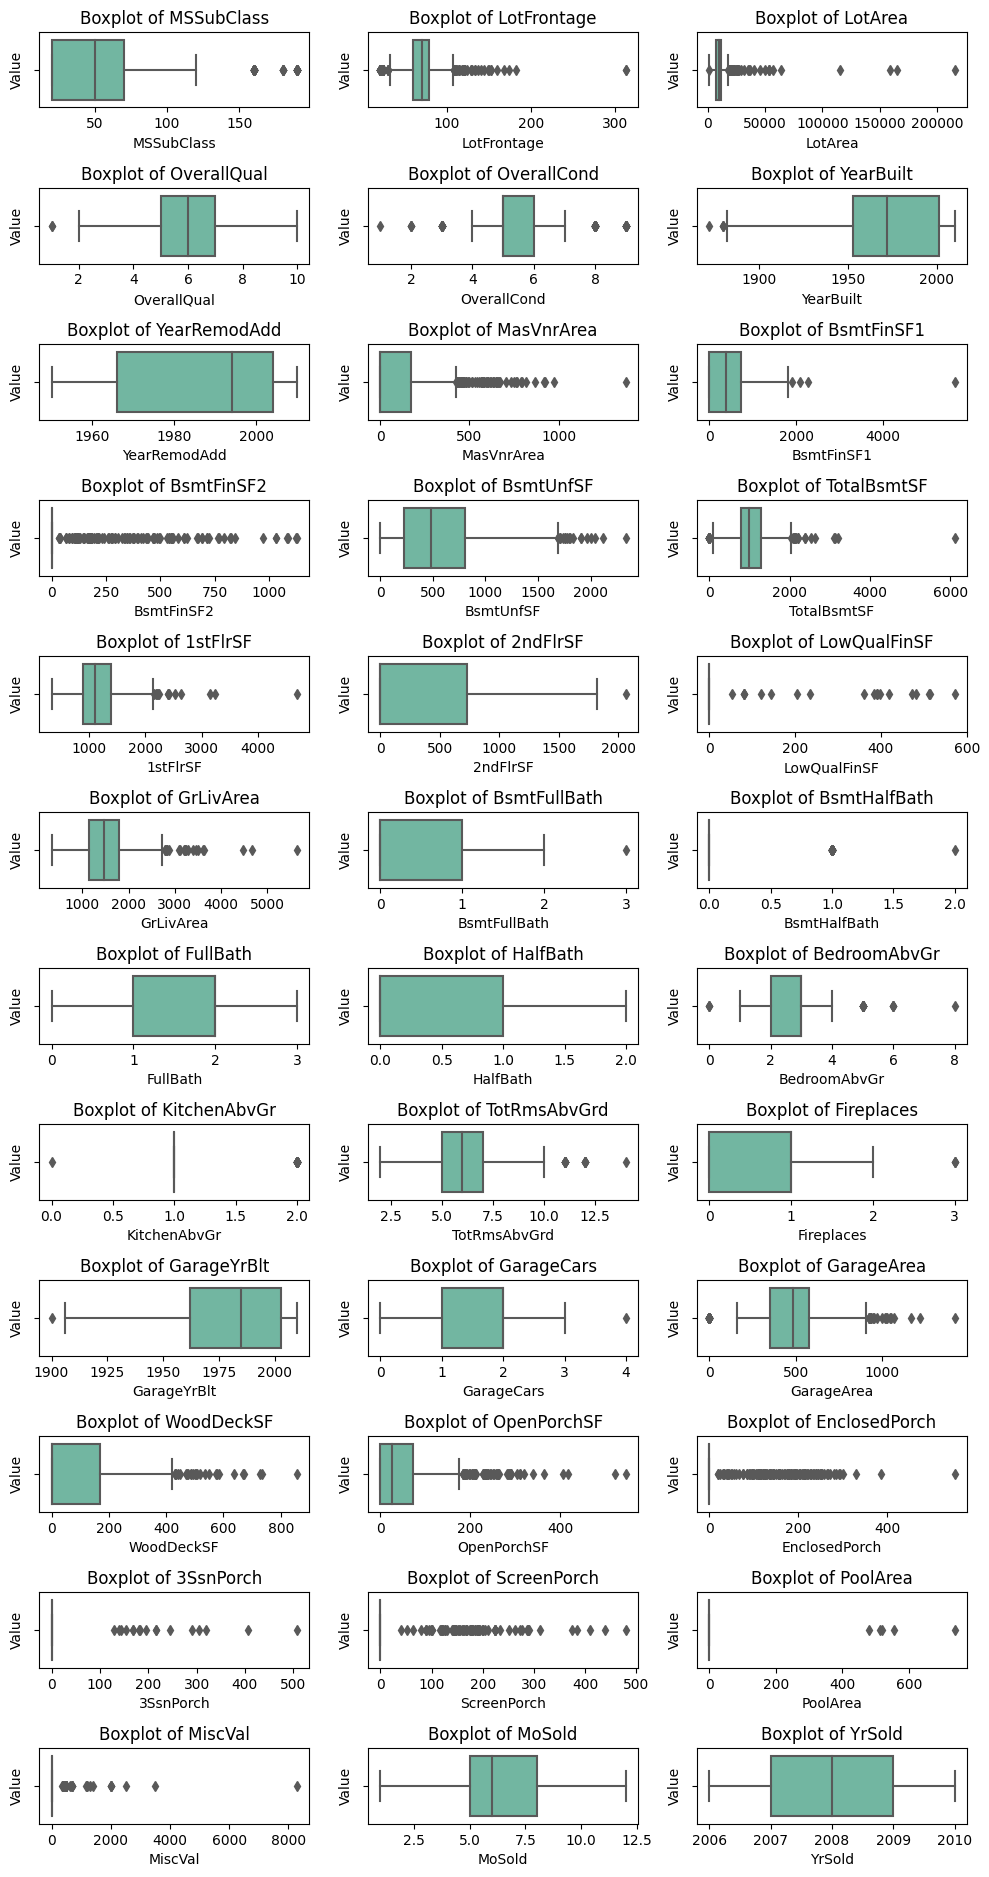

In [31]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=train_set[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


<span style="font-family:Comic Sans MS; color:red">Plot a specific boxplot. Insert column name below : </span>


In [32]:
specific_column = 'MSSubClass'

Text(0, 0.5, 'Value')

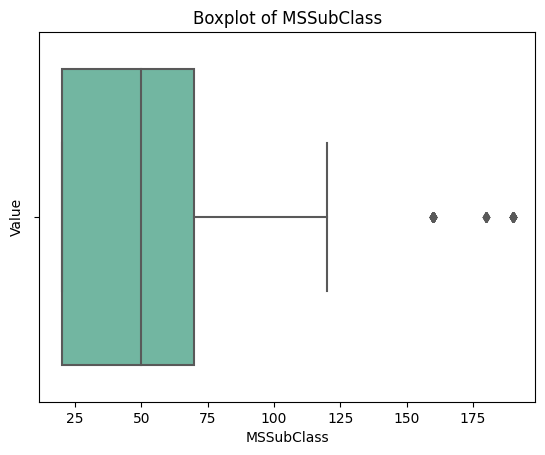

In [33]:
# Plot a specific boxplot
sns.boxplot(x=train_set[specific_column], palette='Set2')
plt.title(f'Boxplot of {specific_column}')
plt.xlabel(specific_column)
plt.ylabel('Value')

## Numerical check for outliers


<span style="font-family:Comic Sans MS; color:red"> Let's numerically extract the columns with outliers ! </span>


In [34]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in numerical_columns: 
    # Calculate IQR
    iqr_value = iqr(train_set[col])

    #Calculate 1st quartile
    q1 = np.percentile(train_set[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(train_set[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = train_set[col] < outlier_lim_low
    number_outliers_low = len(train_set[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = train_set[col] > outlier_lim_high
    number_outliers_high = len(train_set[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
    
#     print(f'------------------  {col}  -----------------------')
#     print(f'Number of outliers : {number_outliers_total}')
#     print('---------------------------------------------------')
    
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITH outliers :  </span>



In [35]:
numerical_columns_w_outliers

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITHOUT outliers :  </span>



In [36]:
numerical_columns_no_outliers

['YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold']

# Scaling




## Columns WITH outliers : Robust scaling




<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




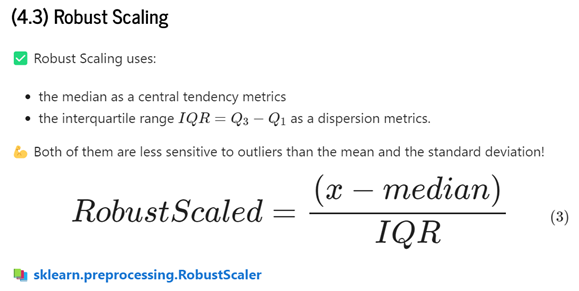


In [37]:
# Describe columns with outliers
train_set[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,57.059687,70.375000,10745.437378,6.128180,5.564579,1970.995108,104.952055,446.176125,42.368885,571.223092,1059.768102,1169.737769,353.738748,5.766145,1529.242661,0.422701,0.059687,2.890411,1.045010,6.545010,0.613503,1980.067515,1.783757,477.120352,97.548924,49.525440,21.303327,3.881605,15.565558,2.743640,41.565558
std,42.669715,23.035615,11329.753423,1.371391,1.110557,30.748816,172.547873,459.971174,151.210531,446.004532,447.423437,389.550515,441.124963,47.949564,530.971805,0.519354,0.241119,0.811116,0.212096,1.630221,0.650724,24.857800,0.730751,208.443296,131.691873,69.205968,61.534380,32.547722,56.445749,39.671531,338.132358
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7564.250000,5.000000,5.000000,1953.000000,0.000000,0.000000,0.000000,223.250000,795.000000,889.750000,0.000000,0.000000,1142.500000,0.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,350.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,70.375000,9600.000000,6.000000,5.000000,1972.000000,0.000000,390.000000,0.000000,483.500000,995.000000,1096.500000,0.000000,0.000000,1476.500000,0.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1985.000000,2.000000,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,79.000000,11692.500000,7.000000,6.000000,2001.000000,170.000000,724.000000,0.000000,809.500000,1294.000000,1392.000000,731.250000,0.000000,1794.250000,1.000000,0.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,170.500000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,8.000000,2.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000


In [38]:
#Instanciate, fit, transform with robust scaler
rb_scaler = RobustScaler()
train_set[numerical_columns_w_outliers] = rb_scaler.fit_transform(train_set[numerical_columns_w_outliers])

In [39]:
# Describe columns with outliers after robust scaling
train_set[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1022.000000,1.022000e+03,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.141194,6.952473e-18,0.277463,0.064090,0.564579,-0.020935,0.617365,0.077591,42.368885,0.149634,0.129796,0.145819,0.483745,5.766145,0.080925,0.422701,0.059687,-0.109589,0.045010,0.272505,-0.386497,-0.120305,-0.216243,-0.030508,0.572134,0.308568,21.303327,3.881605,15.565558,2.743640,41.565558
std,0.853394,1.212401e+00,2.744445,0.685696,1.110557,0.640600,1.014987,0.635319,151.210531,0.760775,0.896640,0.775611,0.603248,47.949564,0.814686,0.519354,0.241119,0.811116,0.212096,0.815110,0.650724,0.606288,0.730751,0.924361,0.772386,0.948027,61.534380,32.547722,56.445749,39.671531,338.132358
min,-0.600000,-2.598684e+00,-2.010537,-2.500000,-4.000000,-2.083333,0.000000,-0.538674,0.000000,-0.824733,-1.993988,-1.518168,0.000000,0.000000,-1.752973,0.000000,0.000000,-3.000000,-1.000000,-2.000000,-1.000000,-2.073171,-2.000000,-2.146341,0.000000,-0.369863,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,-5.460526e-01,-0.493127,-0.500000,0.000000,-0.395833,0.000000,-0.538674,0.000000,-0.443923,-0.400802,-0.411648,0.000000,0.000000,-0.512466,0.000000,0.000000,-1.000000,0.000000,-0.500000,-1.000000,-0.560976,-1.000000,-0.592018,0.000000,-0.369863,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,4.539474e-01,0.506873,0.500000,1.000000,0.604167,1.000000,0.461326,0.000000,0.556077,0.599198,0.588352,1.000000,0.000000,0.487534,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.439024,0.000000,0.407982,1.000000,0.630137,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.800000,1.276974e+01,49.814086,2.000000,4.000000,0.791667,8.105882,7.256906,1127.000000,3.159915,10.250501,7.158785,2.823932,572.000000,6.391254,3.000000,2.000000,5.000000,1.000000,4.000000,2.000000,0.609756,2.000000,4.141907,5.026393,7.123288,552.000000,508.000000,480.000000,738.000000,8300.000000


In [40]:
# list processed columns
for col in numerical_columns_w_outliers:
    processed.append(col)

## Columns WITHOUT outliers



### Quick visual check




<span style="font-family:Comic Sans MS; color:red">Quick visual check for columns WITHOUT outliers !  </span>


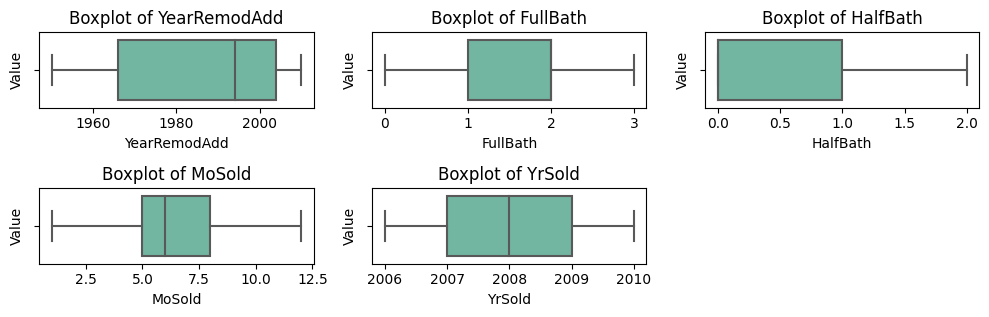

In [41]:
# display boxplots of columns with no outliers
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns_no_outliers, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=train_set[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

### Distribution of columns WITHOUT outliers



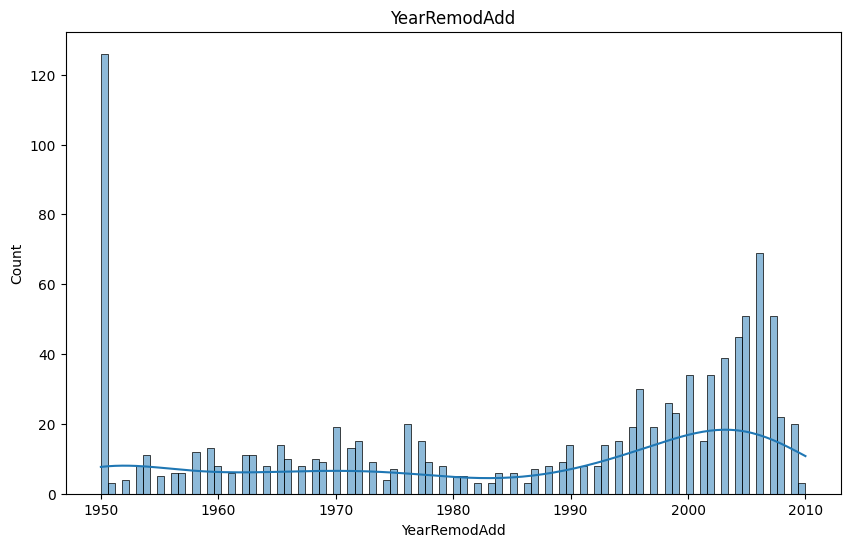

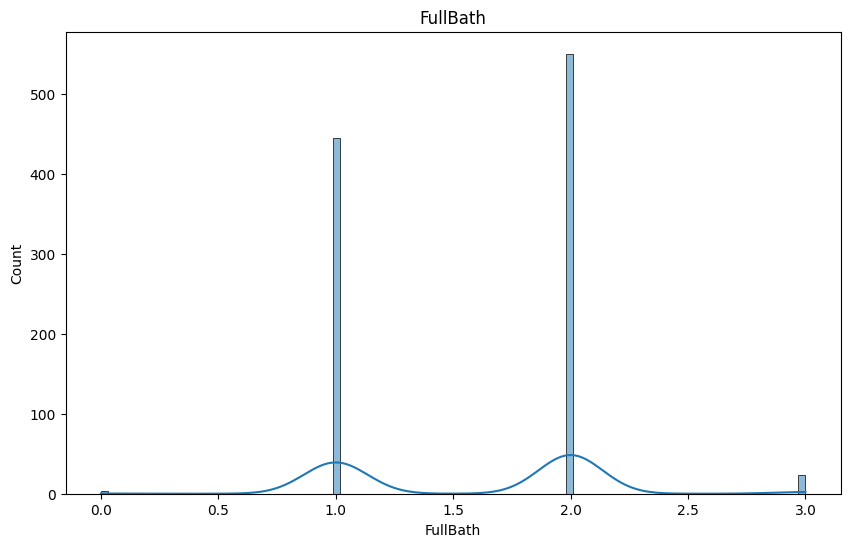

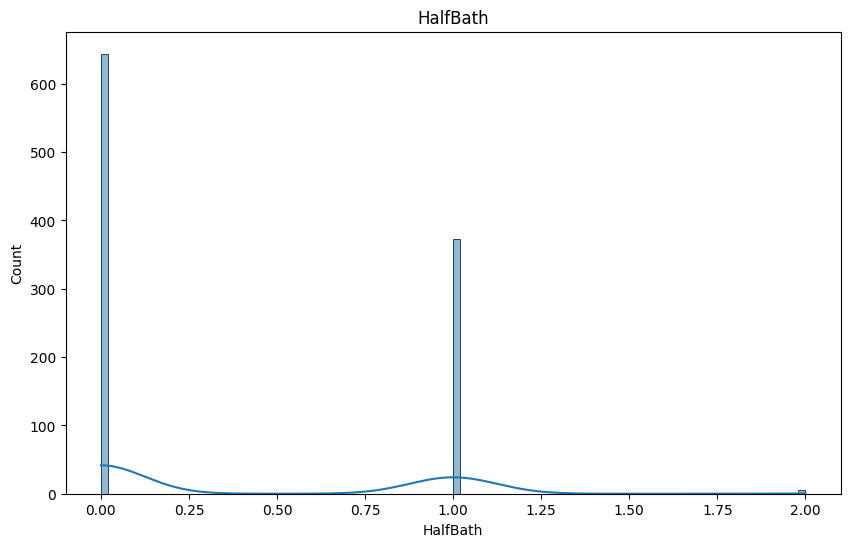

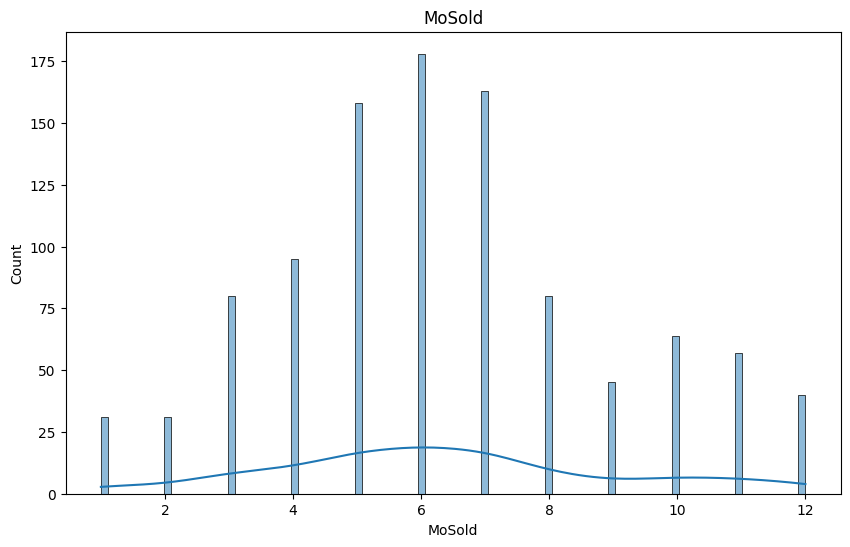

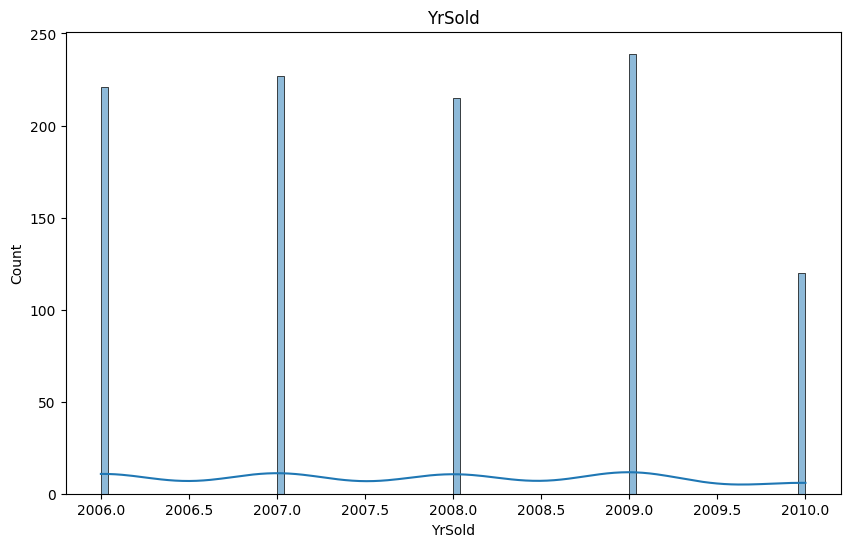

In [42]:
# Display hist plots for numerical features with no outliers.
for col in numerical_columns_no_outliers:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_set[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

###  Implement Minmax Scaling



<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




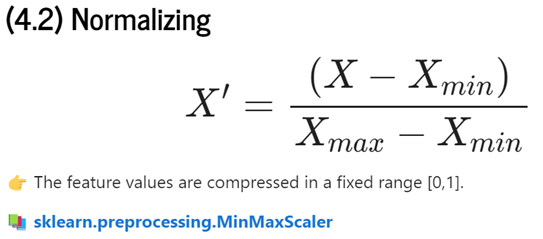


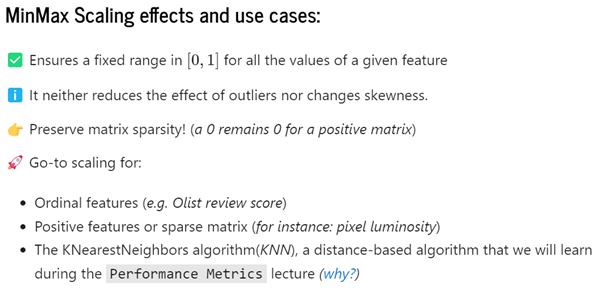


In [43]:
# Describe columns with NO outliers
train_set[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,MoSold,YrSold
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,1984.757339,1.582192,0.374755,6.363992,2007.814090
std,20.747109,0.544401,0.494305,2.650115,1.325807
min,1950.000000,0.000000,0.000000,1.000000,2006.000000
25%,1966.000000,1.000000,0.000000,5.000000,2007.000000
50%,1994.000000,2.000000,0.000000,6.000000,2008.000000
75%,2004.000000,2.000000,1.000000,8.000000,2009.000000
max,2010.000000,3.000000,2.000000,12.000000,2010.000000


In [44]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
train_set[numerical_columns_no_outliers] = minmax_scaler.fit_transform(train_set[numerical_columns_no_outliers])

In [45]:
# Describe columns with NO outliers after minmax scaling
train_set[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,MoSold,YrSold
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.579289,0.527397,0.187378,0.487636,0.453523
std,0.345785,0.181467,0.247153,0.240920,0.331452
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.266667,0.333333,0.000000,0.363636,0.250000
50%,0.733333,0.666667,0.000000,0.454545,0.500000
75%,0.900000,0.666667,0.500000,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
# list processed columns
for col in numerical_columns_no_outliers:
    processed.append(col)

## Copy



<span style="font-family:Comic Sans MS; color:red"> Copy the dataframe after SCALING : </span>








In [47]:
traditional_scaling_df = train_set.copy()
traditional_scaling_df


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
135,-0.6,RL,0.506579,0.193787,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,0.5,1.0,-0.041667,0.333333,Hip,CompShg,Plywood,Plywood,BrkFace,1.694118,TA,TA,PConc,TA,TA,No,Unf,-0.538674,Unf,0.0,1.399574,0.619238,GasA,Gd,Y,SBrkr,1.165754,0.000000,0.0,0.315305,0.0,0.0,0.666667,0.0,0.0,0.0,TA,0.5,Typ,0.0,Gd,Attchd,-0.365854,Unf,0.0,0.203991,TA,TA,Y,0.574780,-0.369863,0.0,0.0,0.0,0.0,MnPrv,0.0,0.363636,0.50,WD,Normal,174000
1452,2.6,RM,-1.861842,-1.435233,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,-0.5,0.0,0.687500,0.916667,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.470588,TA,TA,PConc,Gd,TA,Gd,GLQ,0.216851,Unf,0.0,-0.824733,-0.897796,GasA,Gd,Y,SBrkr,-0.048780,0.000000,0.0,-0.620637,1.0,0.0,0.333333,0.0,-1.0,0.0,TA,-0.5,Typ,-1.0,NA,Basment,0.487805,Fin,0.0,0.181818,TA,TA,Y,0.000000,0.013699,0.0,0.0,0.0,0.0,NA,0.0,0.363636,0.00,WD,Normal,145000
762,0.2,FV,0.085526,-0.232544,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,0.5,0.0,0.770833,0.983333,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,Mn,GLQ,-0.505525,Unf,0.0,0.423881,-0.478958,GasA,Ex,Y,SBrkr,-0.662021,1.070769,0.0,0.108170,0.0,0.0,0.666667,0.5,0.0,0.0,Gd,0.5,Typ,-1.0,NA,Attchd,0.585366,Unf,0.0,0.576497,TA,TA,Y,0.991202,0.246575,0.0,0.0,0.0,0.0,NA,0.0,0.454545,1.00,Con,Normal,215200
932,-0.6,RL,0.717105,0.501423,Pave,IR1,Lvl,AllPub,Corner,Gtl,Somerst,RRNn,Norm,1Fam,1Story,1.5,0.0,0.708333,0.933333,Hip,CompShg,VinylSd,ImStucc,Stone,1.776471,Ex,TA,PConc,Ex,Gd,No,Unf,-0.538674,Unf,0.0,2.424733,1.823647,GasA,Ex,Y,SBrkr,1.609756,0.000000,0.0,0.657461,0.0,0.0,0.666667,0.0,0.0,0.0,Ex,1.0,Typ,0.0,Gd,Attchd,0.512195,Fin,1.0,1.348115,TA,TA,Y,0.000000,2.246575,0.0,0.0,0.0,0.0,NA,0.0,0.181818,0.25,WD,Normal,320000
435,0.2,RL,-1.440789,0.258463,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,PosN,Norm,1Fam,2Story,0.5,1.0,0.500000,0.766667,Gable,CompShg,VinylSd,VinylSd,None,0.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,-0.006906,ALQ,344.0,-0.705330,-0.392786,GasA,Ex,Y,SBrkr,-0.536585,1.140513,0.0,0.283084,1.0,0.0,0.666667,0.5,0.0,0.0,Gd,0.0,Typ,0.0,TA,Attchd,0.268293,RFn,0.0,0.292683,TA,TA,Y,0.926686,0.465753,0.0,0.0,0.0,0.0,NA,0.0,0.272727,0.75,ConLw,Normal,212000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.6,RL,0.401316,-0.068552,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,0.0,0.0,0.708333,0.933333,Gable,CompShg,VinylSd,VinylSd,None,0.000000,Gd,TA,PConc,Gd,TA,No,GLQ,-0.505525,Unf,0.0,1.375693,0.639279,GasA,Gd,Y,SBrkr,0.433051,0.000000,0.0,-0.249329,0.0,0.0,0.666667,0.0,0.0,0.0,Gd,0.0,Typ,0.0,Gd,Attchd,0.512195,RFn,0.0,-0.195122,TA,TA,Y,0.000000,-0.068493,0.0,0.0,0.0,0.0,NA,0.0,0.181818,0.25,WD,Normal,176432
1130,0.0,RL,-0.282895,-0.435051,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,-1.0,-2.0,-0.916667,0.000000,Gable,CompShg,WdShing,Plywood,None,0.000000,TA,TA,BrkTil,TA,TA,No,BLQ,0.320442,Unf,0.0,0.028145,0.254509,GasA,TA,Y,SBrkr,0.460926,

# Balancing

<span style="font-family:Comic Sans MS; color:red"> TO BE DEFINED !  </span>





# Encoding


In [48]:
# Extract categorical columns from original dataset
categorical_columns = train_set.select_dtypes(include = 'object').columns
categorical_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

## One hot encoder


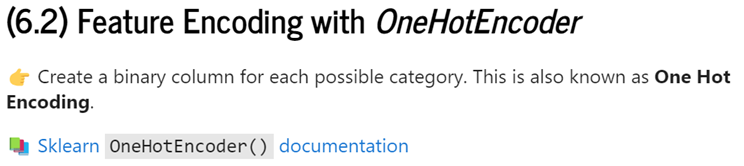


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be OneHotEncoded !  </span>







<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








In [49]:
# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']


In [50]:
# Instantiate, fit
ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
ohe_encoder.fit(train_set[categorical_columns_ohe])

#Transform 
train_set[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(train_set[categorical_columns_ohe]);
print(train_set.shape)

#Drop initial features
train_set.drop(columns=categorical_columns_ohe, inplace=True)
print(train_set.shape)


(1022, 256)
(1022, 229)


In [51]:
# list processed columns
for col in categorical_columns_ohe:
    processed.append(col)

### Copy

<span style="font-family:Comic Sans MS; color:red"> Copy the dataframe after performing OHE and so on : </span>



In [52]:
traditional_ohe_df = train_set.copy()
print(traditional_ohe_df.shape)
traditional_ohe_df;

(1022, 229)


## Ordinal encoder


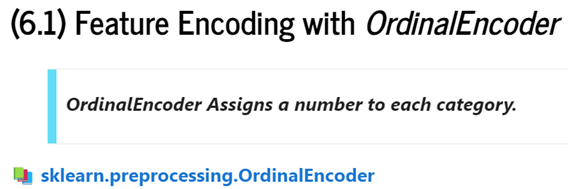


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be Encoded Ordinally !  </span>








<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








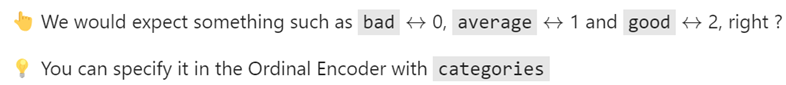


In [53]:
# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual','ExterCond','BsmtQual','BsmtCond', 
                               'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
                               'KitchenQual','FireplaceQu','GarageFinish','GarageQual',
                               'GarageCond']

In [54]:
# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

ordered_categories = [ExterQual_cat, ExterCond_cat,BsmtQual_cat,BsmtCond_cat,
                      BsmtExposure_cat, BsmtFinType1_cat, BsmtFinType2_cat,
                      HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat,
                      GarageFinish_cat, GarageQual_cat, GarageCond_cat]


In [55]:
# Instantiate, fit using ordinal encoding
ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
ordinal_encoder.fit(train_set[categorical_columns_ordinal]);

#Transform
train_set[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(train_set[categorical_columns_ordinal])

print(train_set.shape)

(1022, 229)


In [56]:
# list processed columns
for col in categorical_columns_ordinal:
    processed.append(col)

### Copy


In [57]:
categorical_columns_ordinal


['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [58]:
traditional_ordinal_df = train_set.copy()
print(traditional_ordinal_df.shape)
traditional_ordinal_df


(1022, 229)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_NA,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,-0.6,0.506579,0.193787,0.5,1.0,-0.041667,0.333333,1.694118,2.0,2.0,3.0,3.0,1.0,1.0,-0.538674,1.0,0.0,1.399574,0.619238,3.0,1.165754,0.000000,0.0,0.315305,0.0,0.0,0.666667,0.0,0.0,0.0,2.0,0.5,0.0,4.0,-0.365854,1.0,0.0,0.203991,3.0,3.0,0.574780,-0.369863,0.0,0.0,0.0,0.0,0.0,0.363636,0.50,174000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0

# Check all columns have been processed


In [59]:
# Check that initial columns have all been adressed : 
len(np.unique(processed)) == initial_number_cols

True

# Create pipeline


In [60]:
# Separating train set from test set
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

In [61]:
# Display shapes
print(f"Shape of train_set : {train_set.shape}")
print(f"Shape of test_set : {test_set.shape}")

Shape of train_set : (1022, 81)
Shape of test_set : (438, 81)


## Column Transformer processing missing values



In [62]:
# Function transferring dtypes from one df to another
def get_dtypes_dict(df_in, df_out):
    ''' Takes inputs df_in (original) and df_out (after transformation).
        Returns a dict with new cols from df_out as keys and the dtypes of df_in as values.
    '''
    new_dict = {}
    for key, value in df_in.dtypes.to_dict().items():
        for col in df_out.columns.tolist():
            if f"_{key}" in col:
                new_dict[col] = value
    return new_dict  


In [63]:
# Function reverting back to original columns name
def get_original_names(df_in, df_out):
    '''Takes inputs df_in (original) and df_out (after transformation).
    Returns a dict with df_out column names as keys and df_in columns names as values.    
    '''
    col_dict = {} 
    for col_in in df_in.columns.tolist():
        for col_out in df_out.columns.tolist():
            if f"_{col_in}" in col_out:
                col_dict[col_out] = col_in
    return col_dict    

In [64]:
# Function defining column transformer
def create_col_transform_process_missing():
        # Create transformer     
        transformer = make_column_transformer(
        #Simple Imputer for nan values  
        (SimpleImputer(missing_values = np.nan,strategy='constant', fill_value = "NA"), missing_cols_categorical),

        # List the columns with missing value to be replaced by MEAN value !
        (SimpleImputer(strategy='mean'), missing_cols_numerical_mean),

        # List the columns with missing value to be replaced by MOST FREQUENT value !
        (SimpleImputer(strategy='most_frequent'), missing_cols_numerical_most_freq),

        remainder='passthrough'
        )
        
        return transformer

In [65]:
cols_to_drop


['Id', 'PoolQC', 'MiscFeature', 'Alley']

In [66]:
def get_transformer_process_missing(df):
    '''
    Takes input df, 
    Drop columns,
    create a pipeline processing columns with missing values,
    Fits the pipeline with df,
    Returns a Dataframe with original dtypes, and same column names as df. 
    '''
    # Drop columns 
    print(f"Before dropping : {df.shape}")
    df.drop(columns = cols_to_drop, inplace=True)
    print(f"After dropping : {df.shape}")
    
    # Create pipeline     
    transformer_process_missing = create_col_transform_process_missing()

    # Fit
    transformer_process_missing.fit(df)

    # Create new dataframe with imputed values
    df_imputed = pd.DataFrame(transformer_process_missing.transform(df), 
                               columns=transformer_process_missing.get_feature_names_out())
    
    #Retrieve the dtypes of original df
    df_imputed.astype(get_dtypes_dict(df, df_imputed))

    # Revert to original column names
    df_imputed = df_imputed.rename(columns=get_original_names(df, df_imputed))

    print(f"After processing : {df_imputed.shape}")
    
    return df_imputed,transformer_process_missing


train_set_imputed, transformer_process_missing = get_transformer_process_missing(train_set)
# train_set_pipe_imputed

transformer_process_missing

Before dropping : (1022, 81)
After dropping : (1022, 77)
After processing : (1022, 77)


ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer-1',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Fence', 'FireplaceQu', 'GarageType',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
                                  'BsmtExposure', 'BsmtCond', 'MasVnrType',
                                  'Electrical']),
                                ('simpleimputer-2', SimpleImputer(),
                                 ['LotFrontage']),
                                ('simpleimputer-3',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['MasVnrArea', 'GarageYrBlt'])])

### Check 


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential processing and from transformer processing !  </span>


In [67]:
traditional_process_df_name = 'traditional_process_df'
train_set_imputed_name = 'train_set_imputed_name'

print(f"The sequential way is with : {traditional_process_df_name}")
print(f"The transformer way is with : {train_set_imputed_name}")


The sequential way is with : traditional_process_df
The transformer way is with : train_set_imputed_name


In [68]:
# Order the columns identically
col_order = traditional_process_df.columns.values.tolist()
train_set_imputed = train_set_imputed[col_order]

# Reset the index column of both dataframes to be compared
traditional_process_df.reset_index(drop=True, inplace=True)
train_set_imputed.reset_index(drop=True, inplace=True)

# Actual comparison
result = traditional_process_df.compare(other = train_set_imputed,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("We DO NOT obtain the same dataframe from sequential AND transformer way !!")

We obtain the same dataframe from sequential AND transformer way !!


## Column Transformer dealing with scaling



In [69]:
# Function defining column transformer
def create_col_transform_process_scaling():
        # Create transformer     
        transformer = make_column_transformer(         
            (RobustScaler(), numerical_columns_w_outliers),            
            (MinMaxScaler(),numerical_columns_no_outliers),
            remainder='passthrough'
            )
        
        return transformer  

In [70]:
def get_transformer_process_scaling(df):
    '''
    Takes input df, 
    create a pipeline processing columns with missing values,
    Fits the pipeline with df,
    Returns a Dataframe with original dtypes, and same column names as df. 
    '''
    
    print(f"Before scaling : {df.shape}")
    
    # Create pipeline     
    transformer_process_scaling = create_col_transform_process_scaling()

    # Fit
    transformer_process_scaling.fit(df)

    # Create new dataframe with imputed values
    df_scaled = pd.DataFrame(transformer_process_scaling.transform(df), 
                               columns=transformer_process_scaling.get_feature_names_out())
    
    #Retrieve the dtypes of original df
    df_scaled.astype(get_dtypes_dict(df, df_scaled))

    # Revert to original column names
    df_scaled = df_scaled.rename(columns=get_original_names(df, df_scaled))

    print(f"After scaling : {df_scaled.shape}")
    
    return df_scaled,transformer_process_scaling


train_set_scaled, transformer_process_scaling = get_transformer_process_scaling(train_set_imputed)


Before scaling : (1022, 77)
After scaling : (1022, 77)


In [71]:
transformer_process_scaling

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                                  '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                                  'BsmtFullBath', 'BsmtHalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                                  'GarageCars', 'GarageArea', 'WoodDeckSF',
                                  'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                                  'ScreenPorch', 'PoolArea', ...]),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['YearRemodAdd', 'FullBath', 'HalfBath',
                                  'MoSold', 'YrSold'])])

### Check


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential SCALING and from transformer processing !  </span>




In [72]:
traditional_scaling_df_name = 'traditional_scaling_df'
train_set_scaled_name = 'train_set_scaled'

print(f"The sequential way is with : {traditional_scaling_df_name}")
print(f"The transformer way is with : {train_set_scaled_name}")


The sequential way is with : traditional_scaling_df
The transformer way is with : train_set_scaled


In [73]:
# Order the columns identically
col_order = traditional_scaling_df.columns.values.tolist()
train_set_scaled = train_set_scaled[col_order]

# Reset the index column of both dataframes to be compared
traditional_scaling_df.reset_index(drop=True, inplace=True)
train_set_scaled.reset_index(drop=True, inplace=True)

# Actual comparison
result = traditional_scaling_df.compare(other = train_set_scaled,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("/!\ We DO NOT obtain the same dataframe from sequential AND transformer way !!")

We obtain the same dataframe from sequential AND transformer way !!


In [74]:
result

Empty DataFrame
Columns: []
Index: []

## Column transformer for encoding


### Transformer for One Hot Encoding 


In [75]:
# Function reverting back to original columns name
def get_original_names_ohe(df, str):
    '''Takes inputs df.
    Returns a dict with df column names as keys and columns names WITHOUT str as values.    
    '''
    name_dict={}
    for col in df.columns.tolist():
        if str in col:
            name_dict[col] = col.replace(str, '')
        else:
            name_dict[col] = col
    return name_dict

In [76]:
# Function defining column transformer
def create_col_transform_process_ohe(cols):
        # Create transformer     
        transformer = make_column_transformer(       
            (OneHotEncoder(sparse_output=False,drop = 'if_binary'),cols)
            )   
        return transformer  

In [77]:
def get_transformer_process_ohe(df, cols_ohe):
    '''
    Takes input df, 
    create a pipeline processing columns with missing values,
    Fits the pipeline with df,
    Returns a Dataframe with original dtypes, and same column names as df. 
    '''
    
    print(f"Before ohe : {df.shape}")
    
    # Create pipeline     
    transformer_process_ohe = create_col_transform_process_ohe(cols_ohe)
    
    # Fit
    transformer_process_ohe.fit(df)
    
    #Transform 
    df[transformer_process_ohe.get_feature_names_out()] = transformer_process_ohe.transform(df[cols_ohe]);
       
    print(f"After ohe : {df.shape}")
    
    #Drop initial features
    df.drop(columns=cols_ohe, inplace=True)
    
#     #Copy
#     df_ohe = df.copy()
    
    print(f"After dropping cols_ohe : {df.shape}")
    
    # Revert to original column names
    df =  df.rename(columns = get_original_names_ohe(df, 'onehotencoder__'))
   
    return (df, transformer_process_ohe)


train_set_scaled_ohe, transformer_process_ohe = get_transformer_process_ohe(train_set_scaled, categorical_columns_ohe)



Before ohe : (1022, 77)
After ohe : (1022, 256)
After dropping cols_ohe : (1022, 229)


In [78]:
train_set_scaled_ohe


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_NA,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.6,0.506579,0.193787,0.5,1.0,-0.041667,0.333333,1.694118,TA,TA,TA,TA,No,Unf,-0.538674,Unf,0.0,1.399574,0.619238,Gd,1.165754,0.0,0.0,0.315305,0.0,0.0,0.666667,0.0,0.0,0.0,TA,0.5,0.0,Gd,-0.365854,Unf,0.0,0.203991,TA,TA,0.57478,-0.369863,0.0,0.0,0.0,0.0,0.0,0.363636,0.5,174000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Check

<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential OHE encoding and from transformer processing !  </span>


In [79]:
traditional_ohe_df_name = 'traditional_ohe_df'
train_set_scaled_ohe_name = 'train_set_scaled_ohe'

print(f"The sequential way is with : {traditional_ohe_df_name}")
print(f"The transformer way is with : {train_set_scaled_ohe_name}")

The sequential way is with : traditional_ohe_df
The transformer way is with : train_set_scaled_ohe


In [80]:
# Order the columns identically
col_order = traditional_ohe_df.columns.values.tolist()
train_set_scaled_ohe = train_set_scaled_ohe[col_order]

# Reset the index column of both dataframes to be compared
traditional_ohe_df.reset_index(drop=True, inplace=True)
train_set_scaled_ohe.reset_index(drop=True, inplace=True)

# Actual comparison
result = traditional_ohe_df.compare(other = train_set_scaled_ohe,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("/!\ We DO NOT obtain the same dataframe from sequential AND transformer way !!")

We obtain the same dataframe from sequential AND transformer way !!


### Transformer for Ordinal encoding


In [81]:
# Function defining column transformer
def create_col_transform_process_ordinal(cols):
        # Create transformer     
        transformer = make_column_transformer(               
            (OrdinalEncoder(categories = ordered_categories),cols)
            )   
        return transformer  
    

In [82]:
def get_transformer_process_ordinal(df, cols_ordinal):
    '''
    Takes input df, 
    create a pipeline processing columns with missing values,
    Fits the pipeline with df,
    Returns a Dataframe with original dtypes, and same column names as df. 
    '''
    
    print(f"Before ordinal encoding : {df.shape}")
    
    # Create pipeline     
    transformer_process_ordinal = create_col_transform_process_ordinal(cols_ordinal)

    # Fit
    transformer_process_ordinal.fit(df)

    # Create new dataframe with imputed values    
    df[transformer_process_ordinal.get_feature_names_out()] = transformer_process_ordinal.transform(df[cols_ordinal])
    
    print(f"After ordinal encoding : {df.shape}")
    
    #Drop initial features
    df.drop(columns=cols_ordinal, inplace=True)
    
    print(f"After dropping cols_ordinal : {df.shape}")
    
    # Revert to original column names
    df =  df.rename(columns = get_original_names_ohe(df, 'ordinalencoder__'))

    print(f"After ordinal encoding : {df.shape}")
    
    return df,transformer_process_ordinal


train_set_scaled_ohe_ordinal, transformer_process_ordinal = get_transformer_process_ordinal(train_set_scaled_ohe, categorical_columns_ordinal)

Before ordinal encoding : (1022, 229)
After ordinal encoding : (1022, 242)
After dropping cols_ordinal : (1022, 229)
After ordinal encoding : (1022, 229)


#### Check

<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential ORDINAL encoding and from transformer processing !  </span>



In [83]:
traditional_ordinal_df_name = 'traditional_ordinal_df'
train_set_scaled_ohe_ordinal_name = 'train_set_scaled_ohe_ordinal'

print(f"The sequential way is with : {traditional_ordinal_df_name}")
print(f"The transformer way is with : {train_set_scaled_ohe_ordinal_name}")


The sequential way is with : traditional_ordinal_df
The transformer way is with : train_set_scaled_ohe_ordinal


In [84]:
# Order the columns identically
col_order = traditional_ordinal_df.columns.values.tolist()
train_set_scaled_ohe_ordinal = train_set_scaled_ohe_ordinal[col_order]

# Reset the index column of both dataframes to be compared
traditional_ordinal_df.reset_index(drop=True, inplace=True)
train_set_scaled_ohe_ordinal.reset_index(drop=True, inplace=True)

# Actual comparison
result = traditional_ordinal_df.compare(other = train_set_scaled_ohe_ordinal,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("/!\ We DO NOT obtain the same dataframe from sequential AND transformer way !!")
    

We obtain the same dataframe from sequential AND transformer way !!


## Intermediary pipelines



In [85]:
# Separating train set from test set
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

In [86]:
# Display shapes
print(f"Shape of train_set : {train_set.shape}")
print(f"Shape of test_set : {test_set.shape}")

Shape of train_set : (1022, 81)
Shape of test_set : (438, 81)


In [87]:
#List the columns that won't be used (exemple : Id, Name, ...)
train_set.drop(columns = cols_to_drop, inplace=True)

In [88]:
# categorical columns with missing values
missing_cols_categorical = ['Fence','FireplaceQu','GarageType','GarageFinish','GarageQual',
                            'GarageCond','BsmtQual','BsmtFinType2','BsmtFinType1',
                            'BsmtExposure','BsmtCond','MasVnrType','Electrical']

# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']

# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']

# numerical columns with outliers
numerical_columns_w_outliers = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                                'YearBuilt','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                                'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                                'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                                'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                                'PoolArea','MiscVal']

# numerical columns without outliers
numerical_columns_no_outliers = ['YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold']

# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']

# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

ordered_categories = [ExterQual_cat, ExterCond_cat,BsmtQual_cat,BsmtCond_cat,
                      BsmtExposure_cat, BsmtFinType1_cat, BsmtFinType2_cat,
                      HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat,
                      GarageFinish_cat, GarageQual_cat, GarageCond_cat]

In [89]:
#  Create column transformer to impute missing values
preproc = make_column_transformer(
        #Simple Imputer for nan values  
        (SimpleImputer(missing_values = np.nan,strategy='constant', fill_value = "NA"), missing_cols_categorical),

        # List the columns with missing value to be replaced by MEAN value !
        (SimpleImputer(strategy='mean'), missing_cols_numerical_mean),

        # List the columns with missing value to be replaced by MOST FREQUENT value !
        (SimpleImputer(strategy='most_frequent'), missing_cols_numerical_most_freq),

        remainder='passthrough',
        verbose_feature_names_out =False
        )

# Fit 
preproc.fit(train_set)

ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer-1',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Fence', 'FireplaceQu', 'GarageType',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
                                  'BsmtExposure', 'BsmtCond', 'MasVnrType',
                                  'Electrical']),
                                ('simpleimputer-2', SimpleImputer(),
                                 ['LotFrontage']),
                                ('simpleimputer-3',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['MasVnrArea', 'GarageYrBlt'])],
                  verbose_feature_names_out=False)

In [90]:
# Transform 
train_set_imputed = pd.DataFrame(preproc.transform(train_set), columns=preproc.get_feature_names_out())

In [91]:
#  Create column transformer to scale and encode some columns
scale_encode = make_column_transformer(
            (RobustScaler(), numerical_columns_w_outliers),            
            (MinMaxScaler(),numerical_columns_no_outliers),
            (OneHotEncoder(sparse_output=False,drop = 'if_binary'),categorical_columns_ohe),
            (OrdinalEncoder(categories = ordered_categories),categorical_columns_ordinal),
            remainder='passthrough',
            verbose_feature_names_out =False
            )

# Fit
scale_encode.fit(train_set_imputed)

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                                  '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                                  'BsmtFullBath', 'BsmtHalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvG...
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['NA', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['NA', 'Unf', 'RFn',
                                                             'Fin'],
                                                            ['NA', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['NA', 'Po', 'Fa',
                                                             'TA', 'Gd',
                                                             'Ex']]),
                                 ['ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'FireplaceQu', 'GarageFinish', 'GarageQual',
                                  'GarageCond'])],
                  verbose_feature_names_out=False)

In [96]:
# Transform 
train_set_imp_sc_enc = pd.DataFrame(scale_encode.transform(train_set_imputed), columns=scale_encode.get_feature_names_out())
train_set_imp_sc_enc;


### Check 


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential processing and from transformer processing !  </span>


In [93]:
# Order the columns identically
col_order = train_set_scaled_ohe_ordinal.columns.values.tolist()
train_set_imp_sc_enc = train_set_imp_sc_enc[col_order]

# Reset the index column of both dataframes to be compared
train_set_scaled_ohe_ordinal.reset_index(drop=True, inplace=True)
train_set_imp_sc_enc.reset_index(drop=True, inplace=True)

# Actual comparison
result = train_set_scaled_ohe_ordinal.compare(other = train_set_imp_sc_enc,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("We DO NOT obtain the same dataframe from sequential AND transformer way !!")


We obtain the same dataframe from sequential AND transformer way !!


## Final pipeline




In [254]:
# Separating train set from test set
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

In [255]:
# Display shapes
print(f"Shape of train_set : {train_set.shape}")
print(f"Shape of test_set : {test_set.shape}")

Shape of train_set : (1022, 81)
Shape of test_set : (438, 81)


In [256]:
#List the columns that won't be used (exemple : Id, Name, ...)
train_set.drop(columns = cols_to_drop, inplace=True)

In [257]:
# categorical columns with missing values
missing_cols_categorical = ['Fence','FireplaceQu','GarageType','GarageFinish','GarageQual',
                            'GarageCond','BsmtQual','BsmtFinType2','BsmtFinType1',
                            'BsmtExposure','BsmtCond','MasVnrType','Electrical']

# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']

# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']

# numerical columns with outliers
numerical_columns_w_outliers = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                                'YearBuilt','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                                'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                                'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                                'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                                'PoolArea','MiscVal']

# numerical columns without outliers
numerical_columns_no_outliers = ['YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold']

# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']

# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

ordered_categories = [ExterQual_cat, ExterCond_cat,BsmtQual_cat,BsmtCond_cat,
                      BsmtExposure_cat, BsmtFinType1_cat, BsmtFinType2_cat,
                      HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat,
                      GarageFinish_cat, GarageQual_cat, GarageCond_cat]


ordered_categories_sim_imp_na__ordinal_p = [FireplaceQu_cat,
                                             BsmtFinType1_cat,
                                             GarageCond_cat,
                                             BsmtFinType2_cat,
                                             BsmtQual_cat,
                                             GarageFinish_cat,
                                             GarageQual_cat,
                                             BsmtCond_cat,
                                             BsmtExposure_cat]

ordered_categories_imp_remainer__ordinal = [ExterQual_cat, HeatingQC_cat, KitchenQual_cat, ExterCond_cat]

In [258]:
#  Lists
simple_imp_na = missing_cols_categorical
simple_imp_mean = missing_cols_numerical_mean
simple_imp_mf = missing_cols_numerical_most_freq
imp_remainer = []

rb_scaler = numerical_columns_w_outliers
minmax = numerical_columns_no_outliers
ohe = categorical_columns_ohe
ordinal = categorical_columns_ordinal

In [259]:
# IMPUTER
simple = [simple_imp_na, simple_imp_mean, simple_imp_mf]
temp = train_set.columns.tolist()

print(len(temp))
for liste in simple:
    for element in liste:
        temp.remove(element)
print(len(temp))

imp_remainer = temp
simple = [simple_imp_na, simple_imp_mean, simple_imp_mf, imp_remainer]

total = 0
for lis in simple:
    total = total + len(lis)
print(total)

77
61
77


In [260]:
# SCALING + ENCODING
scale = [rb_scaler, minmax, ohe, ordinal]
temp = train_set.columns.tolist()

print(len(temp))
for liste in scale:
    for element in liste:
        temp.remove(element)
print(len(temp))
temp
scale_remainer = temp
scale = [rb_scaler, minmax, ohe, ordinal,scale_remainer]

total = 0
for lis in scale:
    total = total + len(lis)
print(total)

77
1
77


In [261]:
# Dicts
dict_imp = {'sim_imp_na' : simple_imp_na,
           'sim_imp_mean' : simple_imp_mean,
           'sim_imp_mf' : simple_imp_mf,
           'imp_remainer' : imp_remainer}

dict_sc_enc = {'rb_scaler': rb_scaler,
                'minmax': minmax,
                'ohe': ohe,
                'ordinal': ordinal,
                'scale_remainer' : scale_remainer}

In [271]:
# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Driver Code
dict = {}
for key_i, value_i in dict_imp.items():
    for key, value in dict_sc_enc.items():   
        inter = intersection(value_i, value)
        if len(inter) > 0:
#             print(f"-- {key_i}__{key} : {inter}\n")
            dict[f"{key_i}__{key}"] = inter        

In [265]:
# Create pipelines

# sim_imp_na__ohe 
sim_imp_na__ohe_p = make_pipeline(SimpleImputer(missing_values = np.nan,strategy='constant', fill_value = "NA"),
                                OneHotEncoder(sparse_output=False,drop = 'if_binary'))

# sim_imp_na__ordinal 
sim_imp_na__ordinal_p = make_pipeline(SimpleImputer(missing_values = np.nan,strategy='constant', fill_value = "NA"),
                                     OrdinalEncoder(categories = ordered_categories_sim_imp_na__ordinal_p))

# # sim_imp_na__ordinal 
# sim_imp_na__ordinal_p = make_pipeline(SimpleImputer(missing_values = np.nan,strategy='constant', fill_value = "NA"),
#                                      OrdinalEncoder(categories = ordered_categories))

# sim_imp_mean__rb_scaler 
sim_imp_mean__rb_scaler_p = make_pipeline(SimpleImputer(strategy='mean'),RobustScaler())

# sim_imp_mf__rb_scaler 
sim_imp_mf__rb_scaler_p = make_pipeline(SimpleImputer(strategy='most_frequent'),RobustScaler())

# imp_remainer__rb_scaler
imp_remainer__rb_scaler_p = RobustScaler()

# imp_remainer__minmax 
imp_remainer__minmax_p = MinMaxScaler()

# imp_remainer__ohe 
imp_remainer__ohe_p = OneHotEncoder(sparse_output=False,drop = 'if_binary')

# imp_remainer__ordinal 
imp_remainer__ordinal_p = OrdinalEncoder(categories = ordered_categories_imp_remainer__ordinal)

# # imp_remainer__ordinal 
# imp_remainer__ordinal_p = OrdinalEncoder(categories = ordered_categories)

# imp_remainer__scale_remainer 
# imp_remainer__scale_remainer_p = ??

In [266]:
preproc_basic = make_column_transformer(
        (sim_imp_na__ohe_p, dict['sim_imp_na__ohe']),
        (sim_imp_na__ordinal_p, dict['sim_imp_na__ordinal']),
        (sim_imp_mean__rb_scaler_p, dict['sim_imp_mean__rb_scaler']),
        (sim_imp_mf__rb_scaler_p, dict['sim_imp_mf__rb_scaler']),
        (imp_remainer__rb_scaler_p, dict['imp_remainer__rb_scaler']),
        (imp_remainer__minmax_p, dict['imp_remainer__minmax']),
        (imp_remainer__ohe_p, dict['imp_remainer__ohe']),
        (imp_remainer__ordinal_p, dict['imp_remainer__ordinal']),
        remainder='passthrough',
        verbose_feature_names_out =False)

preproc_basic.fit(train_set)


ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 ['Fence', 'GarageType', 'Electrical',
                                  'MasVnrType']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='...
                                  'SaleType', 'CentralAir', 'Utilities',
                                  'Street', 'Condition1', 'RoofMatl',
                                  'Foundation', 'LandSlope', 'Heating',
                                  'HouseStyle', 'Neighborhood']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex']]),
                                 ['ExterQual', 'HeatingQC', 'KitchenQual',
                                  'ExterCond'])],
                  verbose_feature_names_out=False)

In [267]:
res_df = pd.DataFrame(preproc_basic.transform(train_set), columns=preproc_basic.get_feature_names_out())
res_df

,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_NA,Electrical_SBrkr,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,FireplaceQu,BsmtFinType1,GarageCond,BsmtFinType2,BsmtQual,GarageFinish,GarageQual,BsmtCond,BsmtExposure,LotFrontage,GarageYrBlt,MasVnrArea,OpenPorchSF,2ndFlrSF,MSSubClass,1stFlrSF,ScreenPorch,PoolArea,TotRmsAbvGrd,MiscVal,Fireplaces,YearBuilt,BsmtHalfBath,WoodDeckSF,TotalBsmtSF,3SsnPorch,KitchenAbvGr,OverallCond,BsmtUnfSF,GarageCars,BedroomAbvGr,BsmtFinSF2,LowQualFinSF,BsmtFinSF1,GrLivArea,LotArea,OverallQual,BsmtFullBath,GarageArea,EnclosedPorch,YearRemodAdd,YrSold,MoSold,HalfBath,FullBath,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,CentralAir_Y,Utilities_NoSeWa,Street_Pave,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterQual,HeatingQC,KitchenQual,ExterCond,SalePrice
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.506579,-0.365854,1.694118,-0.369863,0.000000,-0.6,1.165754,0.0,0.0,0.5,0.0,0.0,-0.041667,0.0,0.574780,0.619238,0.0,0.0,1.0,1.399574,0.0,0.0,0.0,0.0,-0.538674,0.315305,0.193787,0.5,0.0,0.203991,0.0,0.333333,0.50,0.363636,0.0,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.

### Check

<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY check the difference between the processed data from sequential processing and from transformer processing !  </span>


In [268]:
# Order the columns identically
col_order = train_set_imp_sc_enc.columns.values.tolist()
res_df = res_df[col_order]

# Reset the index column of both dataframes to be compared
train_set_imp_sc_enc.reset_index(drop=True, inplace=True)
res_df.reset_index(drop=True, inplace=True)

# Actual comparison
result = train_set_imp_sc_enc.compare(other = res_df,
                                        align_axis = 1,
                                        keep_shape = False,
                                        keep_equal = False,)

# Display comparison results
if result.shape == (0,0):
    print("We obtain the same dataframe from sequential AND transformer way !!")
else:
    print("We DO NOT obtain the same dataframe from sequential AND transformer way !!")

We obtain the same dataframe from sequential AND transformer way !!


In [273]:
result

Empty DataFrame
Columns: []
Index: []

# Save the data after preprocessing 


<span style="font-family:Comic Sans MS; color:red"> Let's save the data after preprocessing (cleaning, processing, scaling, encoding, .... )  </span>









In [269]:
# #Create and save json file locally

# #Save the timestamp
# timestamp = time.strftime("%Y%m%d_%H%M%S")

# # Define path to save the data, with specific name
# file_path = os.path.join('../data/processed_data/',f"{timestamp}_processed_train_set.json")

# # Actually saving the dataset in json format
# train_set.to_json(file_path)

In [270]:
# # Check 
# check_df = pd.read_json('../data/processed_data/'+ '20240827_162356_processed_train_set.json')
# check_df.head()